In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay ,log_loss

In [2]:
###------------------------------
### global variables
##-----------------
RANDOM_STATE = 24
np.random.RandomState(seed = RANDOM_STATE)

N_SAMPLE  = 1000
NOISE = .2
ALPHA = .1
TEST_SIZE = .2
EPOCHS = 3000 #NO. of itersation used to optimize weights
# input and output directories

params = {'legend.fontsize' : 'medium', 
          'figure.figsize' : (15, 4),
          'axes.labelsize' : 'medium',
          'axes.titlesize' : 'large',
          'xtick.labelsize' : 'medium',
          'ytick.labelsize' : 'medium',
         }
loss_hist = {} # creating an empty dictionary which will store loss and epoch later so that we can make loss curve later

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm

# plt.style.use('seaborn-v0_8-darkgrid')
plt.style.use('ggplot')

In [3]:
X, y = datasets.make_moons(n_samples = N_SAMPLE, # n_samples: how many datasets in it
                          noise = NOISE, # peportion of randommness added to data so that it matched to real life data , without noise it becomes perfect half circle in moon dataset
                          shuffle = True, 
                          random_state = RANDOM_STATE)
X.shape, y.shape

((1000, 2), (1000,))

In [4]:
y = pd.get_dummies(y).to_numpy()
type(y)
y

array([[ True, False],
       [ True, False],
       [False,  True],
       ...,
       [ True, False],
       [False,  True],
       [ True, False]])

### Activation function

In [6]:
def softmax(z):
    exp_scores = np.exp(z - np.max(z)) # - np.max(z) because the ration will remain unefected as this is getting substracted from every datapoint and the range wil become less which will be easy to calculate
    return exp_scores/ np.sum(exp_scores, axis = 1, keepdims = True)

In [7]:
def fn_actv(z):
    return np.tanh(z)

In [8]:
def fn_actv_prime(z):
    return 1-(np.tanh(z))**2

In [9]:
fn_actv(np.array([[-1,0,1],[-np.inf, 0, np.inf]]))

array([[-0.76159416,  0.        ,  0.76159416],
       [-1.        ,  0.        ,  1.        ]])

In [10]:
def predict(model, X_p): # this function will work as activation function
    W1, b1, W2, b2, W3, b3, W4, b4, W5, b5= model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3'], model['W4'], model['b4'], model['W5'], model['b5']
    m=X_p.shape[0]
    ## forward propagation
    #layer 1
    z1 = X_p.dot(W1) + b1  # aggregation function
    a1 = fn_actv(z1) # activation funvtion
    # Layer 2
    z2 = a1.dot(W2) + b2 # aggregation function for hidden layer
    a2 = fn_actv(z2) # activation
    # Layer 3
    z3 = a2.dot(W3) + b3 # aggregation function for hidden layer
    a3 = fn_actv(z3) # activation
    # Layer 4
    z4 = a3.dot(W4) + b4 # aggregation function for hidden layer
    a4 = fn_actv(z4) # activation
    # Layer 5 output layer
    z5 = a4.dot(W5) + b5 # aggregation function for hidden layer
    a5 = softmax(z5) # activation
    return a5.argmax(axis = 1)

In [11]:
def fn_calculate_loss (model, X_l, y_l):
    W1, b1, W2, b2, W3, b3, W4, b4, W5, b5= model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3'], model['W4'], model['b4'], model['W5'], model['b5']
    m=X_l.shape[0]
    ## forward propagation
    #layer 1
    z1 = X_l.dot(W1) + b1  # aggregation function
    a1 = fn_actv(z1) # activation funvtion
    # Layer 2
    z2 = a1.dot(W2) + b2 # aggregation function for hidden layer
    a2 = fn_actv(z2) # activation
    # Layer 3
    z3 = a2.dot(W3) + b3 # aggregation function for hidden layer
    a3 = fn_actv(z3) # activation
    # Layer 4
    z4 = a3.dot(W4) + b4 # aggregation function for hidden layer
    a4 = fn_actv(z4) # activation
    # Layer 5 output layer
    z5 = a4.dot(W5) + b5 # aggregation function for hidden layer
    a5 = softmax(z5) # activation
    data_loss = -(y_l* np.log(a5) + (1 - y_l) * np.log(1 - a5))
    return data_loss.sum()/m

In [12]:
# features_df = data_df.drop('target', axis=1)
# labels= data_df['target']

In [13]:
X_train, X_test, y_train, y_test=   train_test_split(X,y , random_state= RANDOM_STATE, stratify=y, test_size= TEST_SIZE)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 2), (200, 2), (800, 2), (200, 2))

- why divide by square root of number of rows?
- Dividing weights by the square root of the number of rows (or units) in the previous layer is a technique to initialize neural network weights properly. It helps ensure stable forward and backward propagation, avoiding the problem of exploding or vanishing gradients. This technique is inspired by approaches like Xavier initialization and He initialization, which focus on maintaining a balanced flow of information in the network.
- - The goal of dividing by 
number of rows
number of rows
​
  is to scale the variance of the weights to a reasonable range. Consider:

When weights are initialized randomly, their variance can grow exponentially as it propagates through layers.
Dividing by 
rows
rows
​
  normalizes the variance, preventing it from becoming too large or too small.

In [15]:
rng = np.random.default_rng(seed = RANDOM_STATE)

def build_model(param, X_t, y_t, n_epoch = EPOCHS, alpha = ALPHA): # param(list) carrying parameter numbers in all layers 
    '''
    2-4-1
    '''
    # get dimensions for weight in it
    m = X_t.shape[0] # m is no of rows
    
    # initializing weighs randomly using numoy generator
    W1 = rng.random((param[0], param[1]), dtype= np.float32) / np.sqrt(param[0]) 
    W2 = rng.random((param[1], param[2], ), dtype = np.float32)/ np.sqrt(param[1])
    W3 = rng.random((param[2], param[3], ), dtype = np.float32)/ np.sqrt(param[2])
    W4 = rng.random((param[3], param[4], ), dtype = np.float32)/ np.sqrt(param[3])
    W5 = rng.random((param[4], param[5], ), dtype = np.float32)/ np.sqrt(param[4])

    # initializing bias 
    b1 = np.zeros((1, param[1]), dtype = np.float32)
    b2 = np.zeros((1, param[2]), dtype = np.float32)
    b3 = np.zeros((1, param[3]), dtype = np.float32)
    b4 = np.zeros((1, param[4]), dtype = np.float32)
    b5 = np.zeros((1, param[5]), dtype = np.float32)

    # print(W1.shape, W2.shape, W3.shape, W4.shape, W5.shape)
    curr_loss = 0
    loss = []
    epoch = []
    for i in range(n_epoch):
        ## forward propagation
        #layer 1
        z1 = X_t.dot(W1) + b1  # aggregation function
        a1 = fn_actv(z1) # activation funvtion
        # Layer 2
        z2 = a1.dot(W2) + b2 # aggregation function for hidden layer
        a2 = fn_actv(z2) # activation
        # Layer 3
        z3 = a2.dot(W3) + b3 # aggregation function for hidden layer
        a3 = fn_actv(z3) # activation
        # Layer 4
        z4 = a3.dot(W4) + b4 # aggregation function for hidden layer
        a4 = fn_actv(z4) # activation
        # Layer 5 output layer
        z5 = a4.dot(W5) + b5 # aggregation function for hidden layer
        a5 = softmax(z5) # activation

        ## backpropagation
        # print(y.shape)
        dz5 = a5 - y_t # y should be of shape (1, m)
        dW5 = (a4.T).dot(dz5)
        assert (W5.shape == dW5.shape), f'Shape: W5-{W5.shape} and dw5-{dW5.shape}'

        db5 = np.sum(dz5, axis = 0, keepdims = True)
        assert (b5.shape == db5.shape), f'Shape: b5-{b5.shape} and db5-{db5.shape}'
        da4 = dz5.dot(W5.T)
        assert(a4.shape == da4.shape), f'Shape: a4-{a4.shape} and da4-{da4.shape}'
        
        # layer 4
        dz4 = da4 * fn_actv_prime(z4)
        assert (z4.shape == dz4.shape), f'Shape: z4-{z4.shape} and dz4-{dz4.shape}'
        dW4 = (a3.T).dot(dz4)
        assert (W4.shape== dW4.shape), f'Shape: W4-{W4.shape} and dW4-{dW4.shape}'
        db4= np.sum(dz4, axis=0, keepdims=True)
        assert (b4.shape== db4.shape), f'Shape: b4-{b4.shape} and db4-{db4.shape}'

        da3 = dz4.dot(W4.T)
        # layer 3
        dz3 = da3 * fn_actv_prime(z3)
        assert (z3.shape == dz3.shape), f'Shape: z3-{z3.shape} and dz3-{dz3.shape}'
        dW3 = (a2.T).dot(dz3)
        assert (W3.shape== dW3.shape), f'Shape: W3-{W3.shape} and dW3-{dW3.shape}'
        db3= np.sum(dz3, axis=0, keepdims=True)
        assert (b3.shape== db3.shape), f'Shape: b3-{b3.shape} and db3-{db3.shape}'

        da2 = dz3.dot(W3.T)
        # layer 2
        dz2 = da2 * fn_actv_prime(z2)
        assert (z2.shape == dz2.shape), f'Shape: z2-{z2.shape} and dz2-{dz2.shape}'
        dW2 = (a1.T).dot(dz2)
        assert (W2.shape== dW2.shape), f'Shape: W2-{W2.shape} and dW2-{dW2.shape}'
        db2= np.sum(dz2, axis=0, keepdims=True)
        assert (b2.shape== db2.shape), f'Shape: b2-{b2.shape} and db2-{db2.shape}'

        da1 = dz2.dot(W2.T)
        # layer 1
        dz1 = da1 * fn_actv_prime(z1)
        assert (z1.shape == dz1.shape), f'Shape: z1-{z1.shape} and dz1-{dz1.shape}'
        dW1 = (X_t.T).dot(dz1)
        assert (W1.shape== dW1.shape), f'Shape: W1-{W1.shape} and dW1-{dW1.shape}'
        db1= np.sum(dz1, axis=0, keepdims=True)
        assert (b1.shape== db1.shape), f'Shape: b1-{b1.shape} and db1-{db1.shape}'

        


        #### Gradient Updates

        W1 += - alpha *dW1/m
        W2 += - alpha *dW2/m
        W3 += - alpha *dW3/m
        W4 += - alpha *dW4/m
        W5 += - alpha *dW5/m

        
        b1 += - alpha *db1/m
        b2 += - alpha *db2/m
        b3 += - alpha *db3/m
        b4 += - alpha *db4/m
        b5 += - alpha *db5/m

        model = {'W1':W1, 'b1': b1, 'W2': W2, 'b2' : b2, 'W3' : W3, 'b3' : b3, 'W4' : W4, 'b4' : b4, 'b5': b5, 'W5' : W5}

        if i%100 == 0:
            curr_loss = fn_calculate_loss(model, X_t, y_t)
            loss.append(curr_loss)
            epoch.append(i)
            
        if i%1000 == 0:
            print(f'Loss after {i:>5d} epochs : {curr_loss:0.5f}')


    loss_hist['epoch'] = epoch
    loss_hist['loss'] = loss

    return model
            

In [16]:
layer_params = [X_train.shape[1], 5, 5, 4, 3, y_train.shape[1]]

layer_params

[2, 5, 5, 4, 3, 2]

In [17]:
model = build_model(layer_params, X_train, y_train)

Loss after     0 epochs : 1.40025
Loss after  1000 epochs : 0.59372
Loss after  2000 epochs : 0.15595


In [18]:
y_pred = predict(model, X_train)
accuracy_score(y_train.argmax(axis = 1), y_pred)

0.9725

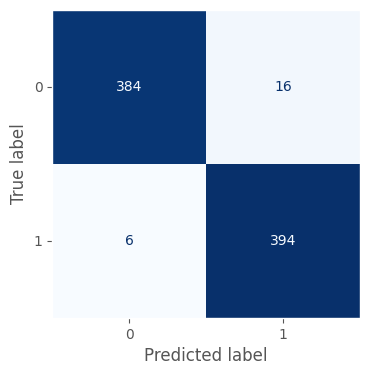

In [19]:
cm = confusion_matrix(y_train.argmax(axis = 1), y_pred)
plost = ConfusionMatrixDisplay(cm, display_labels = [0,1])
fig, ax = plt.subplots(figsize = (4,4))

plost.plot(ax = ax, cmap = 'Blues', colorbar = False)
ax.grid(False)

In [20]:
y_pred = predict(model, X_test)
accuracy_score(y_test.argmax(axis = 1), y_pred)

0.975

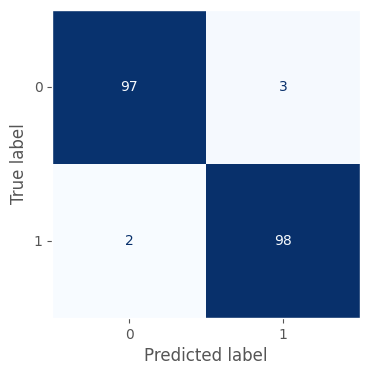

In [21]:
cm = confusion_matrix(y_test.argmax(axis = 1), y_pred)
plost = ConfusionMatrixDisplay(cm, display_labels = [0, 1])
fig, ax = plt.subplots(figsize = (4,4))

plost.plot(ax = ax, cmap = 'Blues', colorbar = False)
ax.grid(False)

<Axes: xlabel='epoch'>

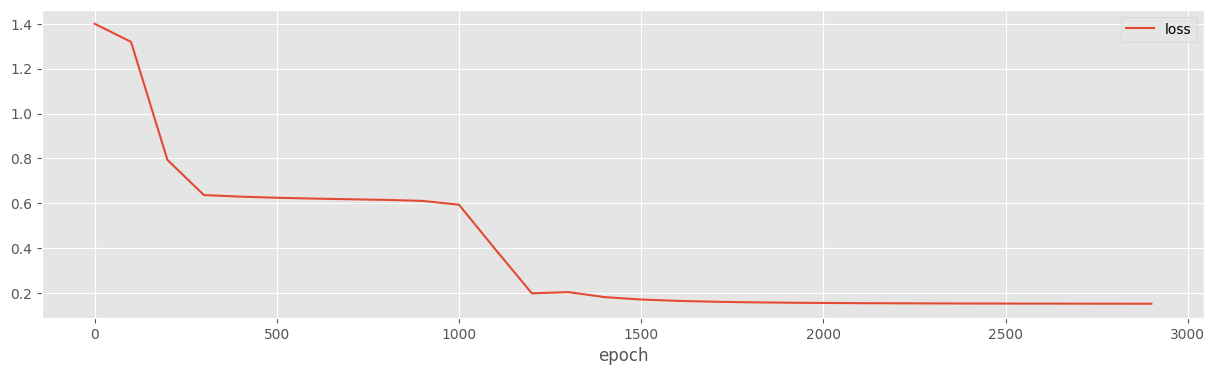

In [22]:
pd.DataFrame(loss_hist).plot(x= 'epoch', y = 'loss')

In [23]:
def fn_plot_decision_boundry(model, X, y, X_ts, y_ts): # x, y are trainig data, X_ts, y_ts are test data
    fig, ax = plt.subplots(figsize =(8,5))
    dm=0.01 # spacing of the grid width
    
    #Min and max along two axis
    x_min, x_max = X[:,0].min(), X[:,0].max()
    y_min, y_max = X[:,1].min(), X[:,1].max()

    # generate a mesh grid
    xx,yy = np.meshgrid(np.arange(x_min, x_max, dm), # creates an array of x-cordinates y no of times
                       np.arange(y_min, y_max, dm)) # creates an array of y-cordinates x no of times
    # Together they create a mesh\
    
    XX = np.c_[xx.ravel(), yy.ravel()]
    
    y_pred= predict(model, XX)

    
    Z = np.array(y_pred).reshape(xx.shape)

    ax.contourf(xx,yy, Z, alpha=0.8, cmap= plt.cm.Paired)
    ax.scatter(X[:,0], X[:,1], c = y.argmax(axis = 1), edgecolors='k', cmap= CMAP)
    ax.scatter(X_ts[:,0], X_ts[:,1], c = y_ts.argmax(axis = 1), edgecolors='k', cmap= CMAP,marker='*')

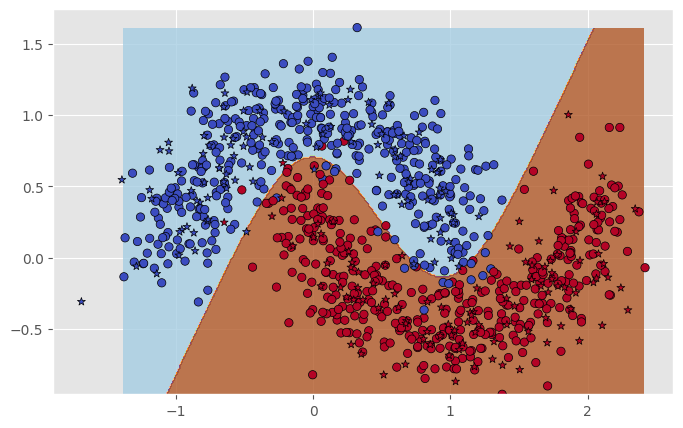

In [24]:
fn_plot_decision_boundry(model, X_train, y_train, X_test, y_test)